## COVID Drivers: Data Exploration

### Table of Contents
* [Read the Data](#read)</BR>
* [Create New Date Variables](#dates)</BR>
* [Find the Best Measure of Central Tendency for Driver Counts](#drv-cnt)</BR>
* [Create Variable Lists](#lists)</BR>
* [Visualize Crash Counts by FLAGS Category](#viz-flags)</BR>
* [Create Aggressive Driving Rates by Date](#aggr-rate)</BR>
* [Visualize Aggressive Driving Rates Over Time](#aggr-viz)

Import packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import ruptures as rpt
import altair as alt

import statsmodels.api as sm

In [2]:
# Import project specific utilities
from utils.functions import *

In [3]:
path_in = 'data/aux/selected_crash_and_flags.csv'

### <a id='read'>Read the data</a>

Read dataset created in covid_drivers_02_DESC.ipynb

In [4]:
df_init = pd.read_csv(path_in, low_memory=False)

### <a id='dates'>Create New Date Variables</a>

In [5]:
df = df_init.copy()

In [6]:
df['POST_COVID'] = [1 if (i > 2020) or (i == 2020 and j >= 3) else 0 for (i, j) in zip(df['CRASH_YEAR'], df['CRASH_MONTH'])]

In [7]:
df['CRASH_MN_NAME'] = pd.to_datetime(df['CRASH_MONTH'], format='%m').dt.month_name().str[:3]

In [8]:
df['CRASH_YEAR'] = df['CRASH_YEAR'].astype('int64').astype('str')

In [9]:
df['CRASH_DATE'] = df.CRASH_YEAR.str.cat( df.CRASH_MN_NAME, sep = '-' )

In [10]:
df['CRASH_DATE'].head()

0    2005-Jan
1    2005-Jan
2    2005-Jan
3    2005-Jan
4    2005-Jan
Name: CRASH_DATE, dtype: str

In [11]:
df['CRASH_DATE'] = pd.to_datetime( df.CRASH_DATE )

/var/folders/ns/b_tjb7711nd7hm27qtmj_83w0000gn/T/ipykernel_60892/892648127.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CRASH_DATE'] = pd.to_datetime( df.CRASH_DATE )


In [12]:
df['CRASH_DATE'].head()

0   2005-01-01
1   2005-01-01
2   2005-01-01
3   2005-01-01
4   2005-01-01
Name: CRASH_DATE, dtype: datetime64[us]

In [13]:
date_cols = ['CRASH_DATE', 
             'CRASH_MONTH', 
             'CRASH_MN_NAME', 
             'CRASH_YEAR', 
             'POST_COVID']

In [14]:
outcome = ['POST_COVID']

### <a id='drv-cnt'>Finding Best Measure of Central Tendency for Driver Counts</a>

In [15]:
cnt_cols = [
 'DRIVER_COUNT_16YR',
 'DRIVER_COUNT_17YR',
 'DRIVER_COUNT_18YR',
 'DRIVER_COUNT_19YR',
 'DRIVER_COUNT_20YR',
 'DRIVER_COUNT_50_64YR',
 'DRIVER_COUNT_65_74YR',
 'DRIVER_COUNT_75PLUS'
]

In [16]:
cnt_cols = []
for c in df.columns.tolist():
    if '_count' in c.lower():
        cnt_cols.append(c)

In [17]:
cnt_cols

['DRIVER_COUNT_16YR',
 'DRIVER_COUNT_17YR',
 'DRIVER_COUNT_18YR',
 'DRIVER_COUNT_19YR',
 'DRIVER_COUNT_20YR',
 'DRIVER_COUNT_50_64YR',
 'DRIVER_COUNT_65_74YR',
 'DRIVER_COUNT_75PLUS']

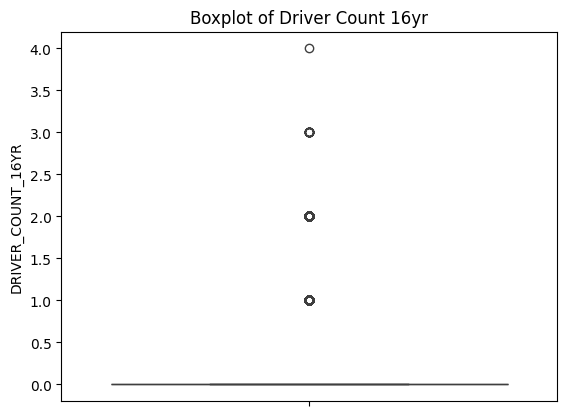

In [18]:
ax = sns.boxplot(y=df['DRIVER_COUNT_16YR'])
ax.set_title('Boxplot of Driver Count 16yr')
plt.show()

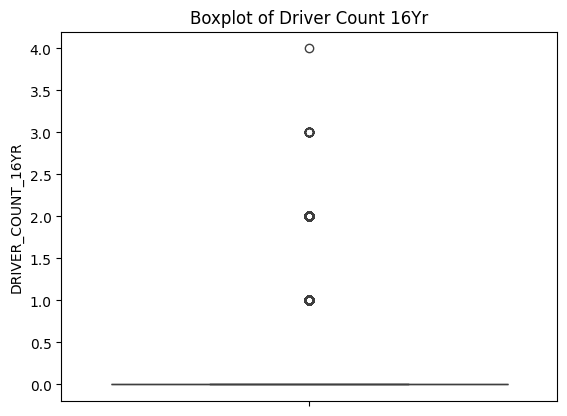

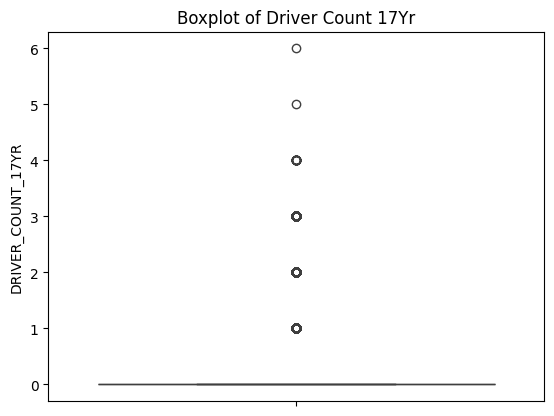

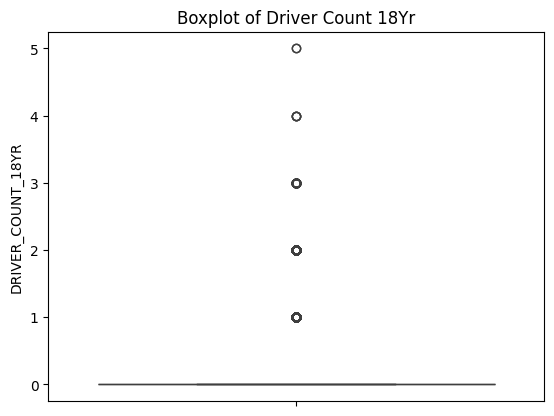

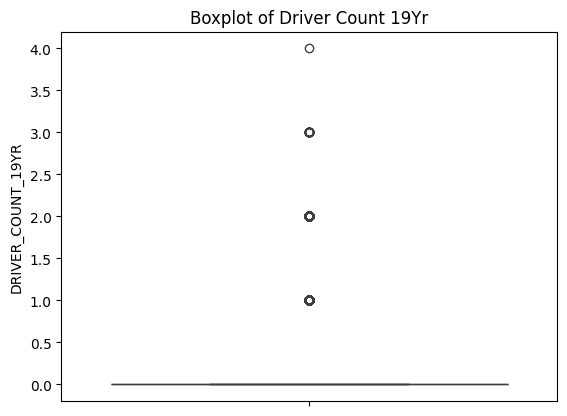

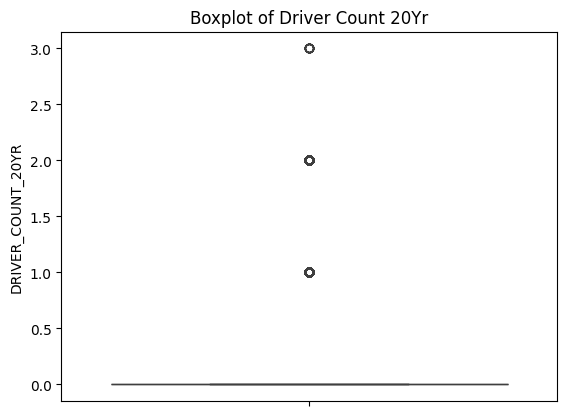

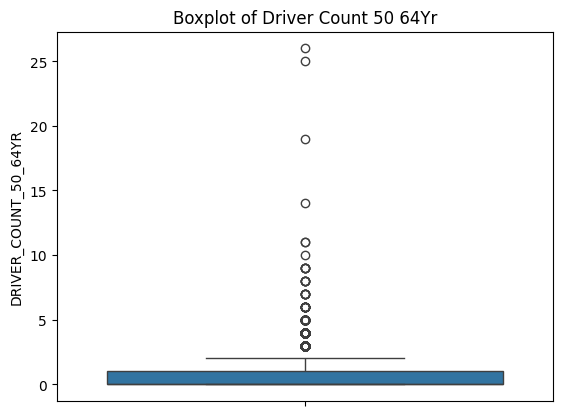

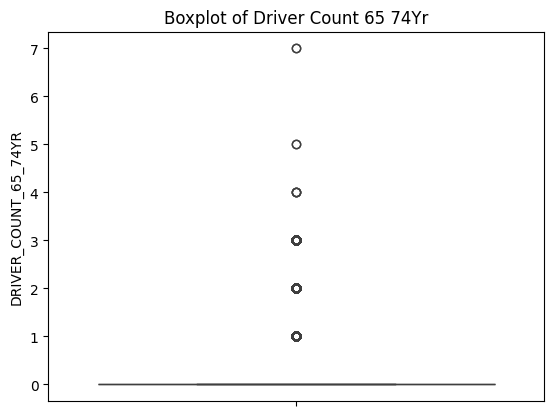

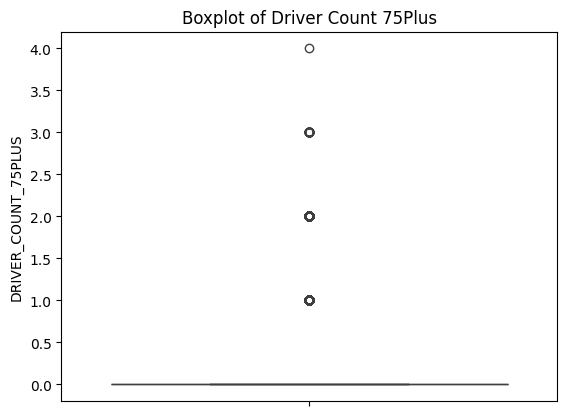

In [19]:
for c in cnt_cols:
    ax = sns.boxplot(y=df[c])
    ax.set_title('Boxplot of ' + c.replace('_',' ').title())
    plt.show()

In [20]:
col_ = []
min_ = []
med_ = []
avg_ = []
mode_ = []
max_ = []

for c in cnt_cols:
    col_.append(c)
    min_.append(df[c].min())
    med_.append(df[c].median())
    avg_.append(df[c].mean())
    mode_.append(df[c].mode()[0])
    max_.append(df[c].max())

summ = pd.DataFrame(list(zip(col_, min_, med_, avg_, mode_, max_)), columns=['COLUMN','MIN','MEDIAN','MEAN','MODE','MAX'])

In [21]:
summ

,COLUMN,MIN,MEDIAN,MEAN,MODE,MAX
0,DRIVER_COUNT_16YR,0,0.0,0.016966,0,4
1,DRIVER_COUNT_17YR,0,0.0,0.043369,0,6
2,DRIVER_COUNT_18YR,0,0.0,0.050474,0,5
3,DRIVER_COUNT_19YR,0,0.0,0.049783,0,4
4,DRIVER_COUNT_20YR,0,0.0,0.047862,0,3
5,DRIVER_COUNT_50_64YR,0,0.0,0.301732,0,26
6,DRIVER_COUNT_65_74YR,0,0.0,0.099876,0,7
7,DRIVER_COUNT_75PLUS,0,0.0,0.066827,0,4


In [22]:
for c in cnt_cols:
    drv_median = df.groupby(['CRASH_DATE']).\
        aggregate(drv_cnt_median=(c, 'median')).\
        reset_index().\
        copy()
    print(c)
    print(drv_median.loc[drv_median['drv_cnt_median']>0].shape[0])
    print()

DRIVER_COUNT_16YR
0

DRIVER_COUNT_17YR
0

DRIVER_COUNT_18YR
0

DRIVER_COUNT_19YR
0

DRIVER_COUNT_20YR
0

DRIVER_COUNT_50_64YR
0

DRIVER_COUNT_65_74YR
0

DRIVER_COUNT_75PLUS
0



### <a id='lists'>Create Variable Lists</a>

In [23]:
all_cols = df.columns.tolist()

In [24]:
aggr_flags = ['AGGRESSIVE_DRIVING',
'NHTSA_AGG_DRIVING',
'NO_CLEARANCE',
'RUNNING_RED_LT',
'RUNNING_STOP_SIGN',
'SPEEDING',
'SPEEDING_RELATED',
'TAILGATING']

In [25]:
date_cols

['CRASH_DATE', 'CRASH_MONTH', 'CRASH_MN_NAME', 'CRASH_YEAR', 'POST_COVID']

In [26]:
geo_cat = ['COUNTY','URBAN_RURAL']

### <a id='viz-flags'>Visualize Crash Counts by FLAGS Category</a>

In [27]:
df.loc[df['POST_COVID']==1]['CRASH_DATE'].min()

Timestamp('2020-03-01 00:00:00')

In [28]:
df['POST_COVIDx'] = ['Before COVID' if x==0 else 'After COVID' for x in df['POST_COVID']]

In [29]:
for c in aggr_flags:
    df[c+'x'] = ['Yes' if x==1 else 'No' if x==0 else np.nan for x in df[c]]

In [30]:
#df.columns.tolist()

#### Count Plots

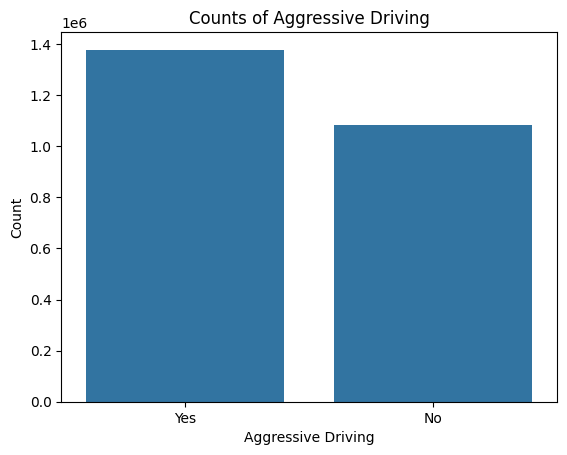

None


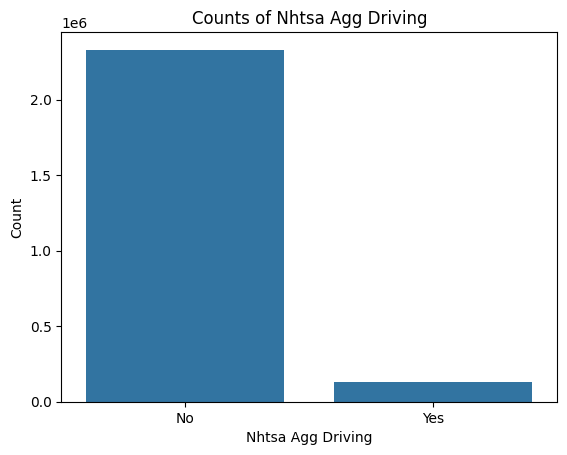

None


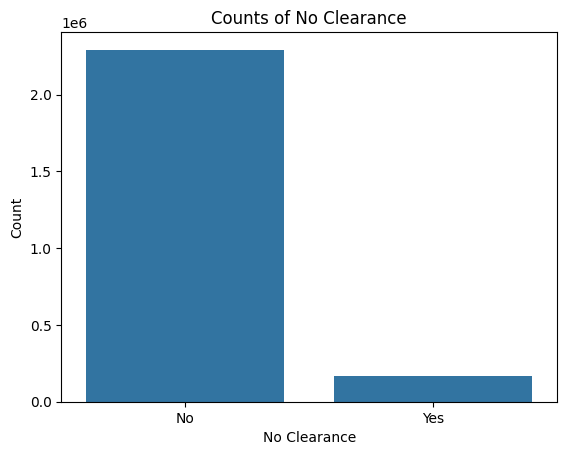

None


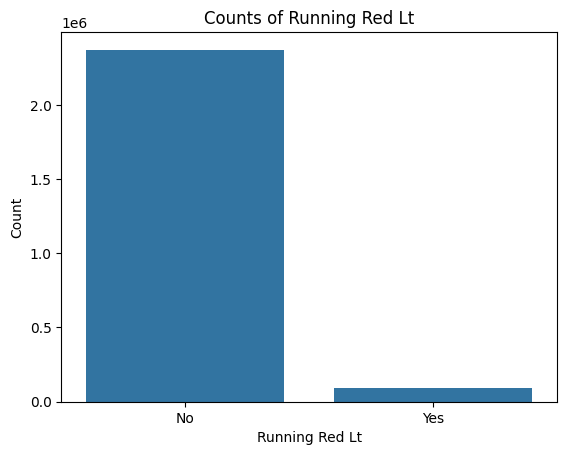

None


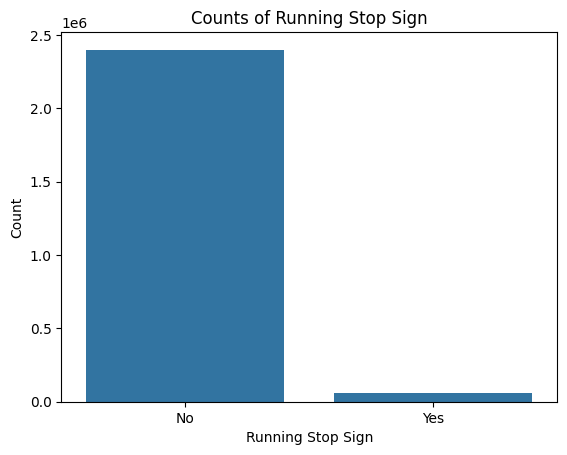

None


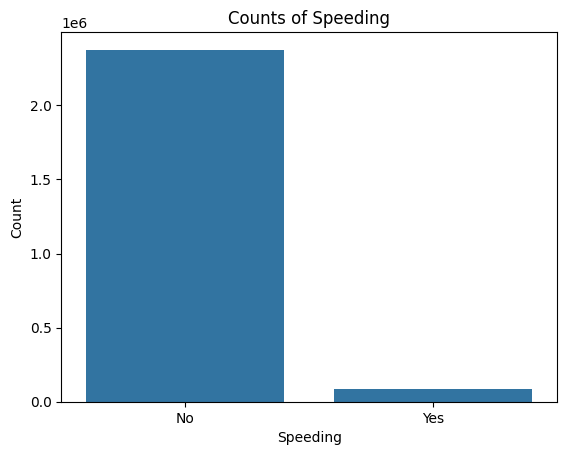

None


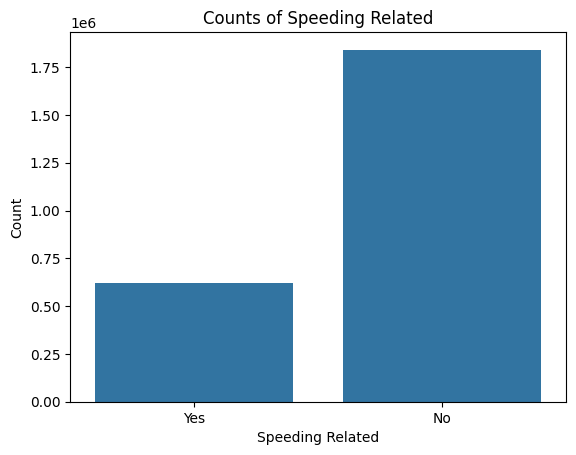

None


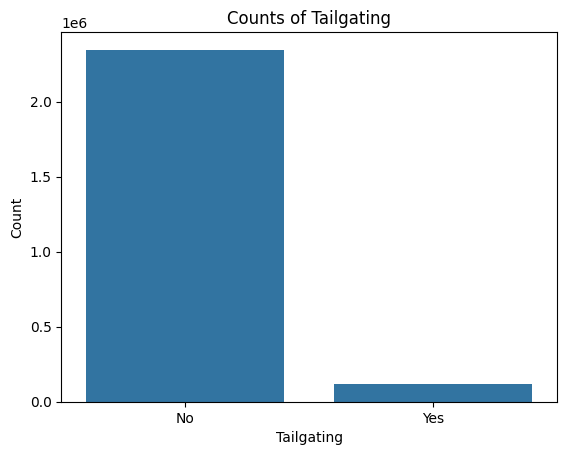

None


In [31]:
for c in aggr_flags:
    cx = c+'x'
    sns.countplot(df, x=cx)
    plt.title('Counts of ' + c.replace('_',' ').title())
    plt.xlabel(c.replace('_',' ').title())
    plt.ylabel('Count')
    plt.savefig('images/countplot_' + c + '.png')
    print(plt.show())

#### Count Plots by Pre/Post COVID

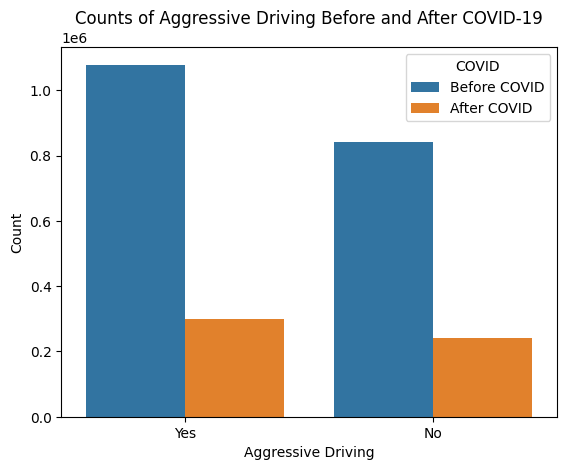

None


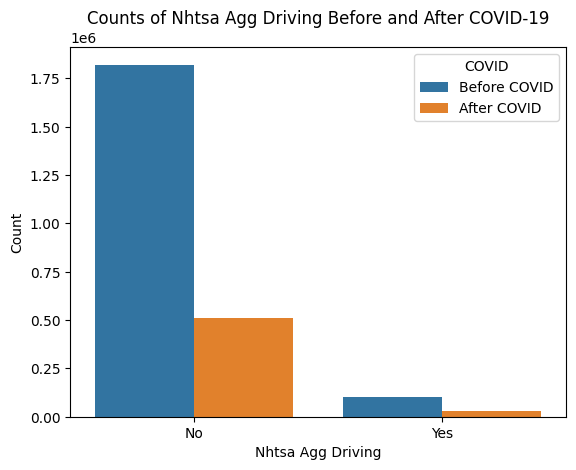

None


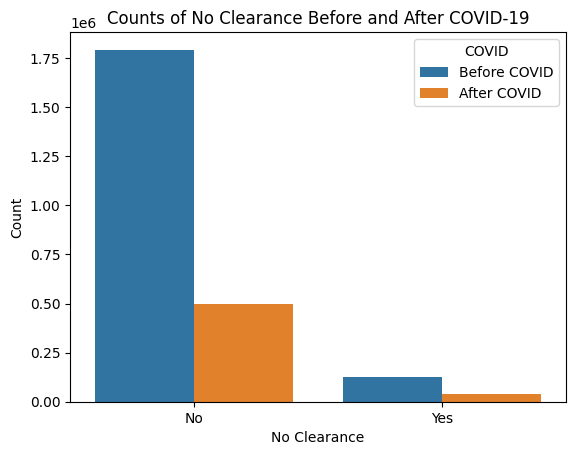

None


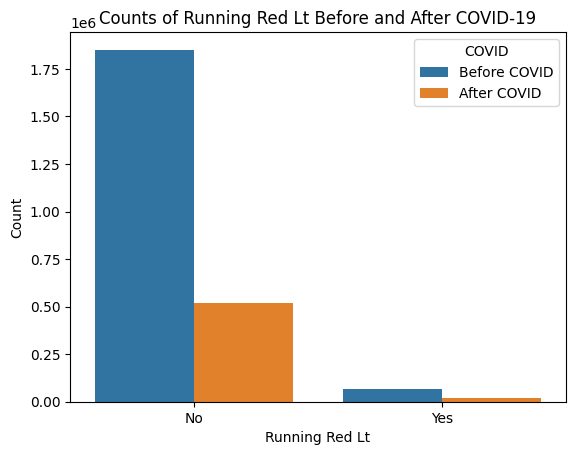

None


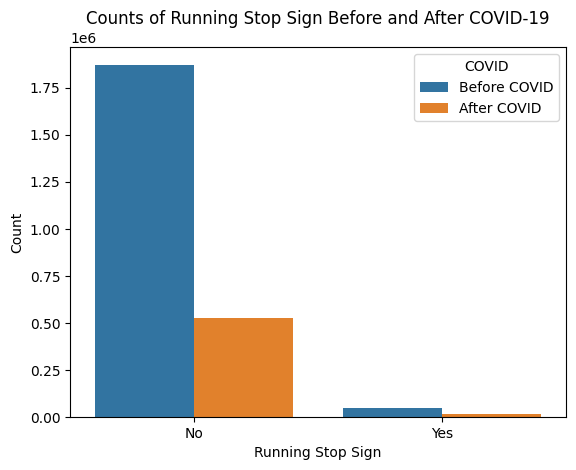

None


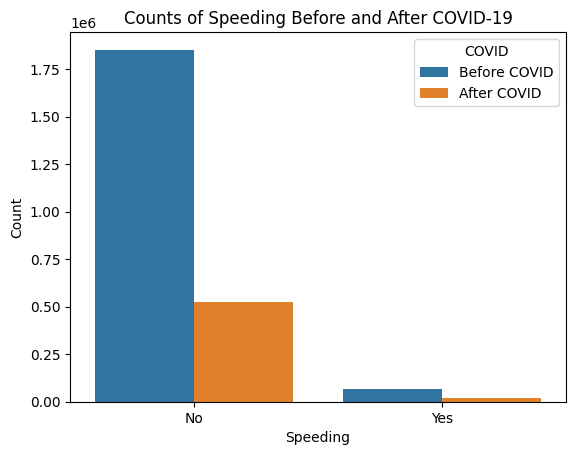

None


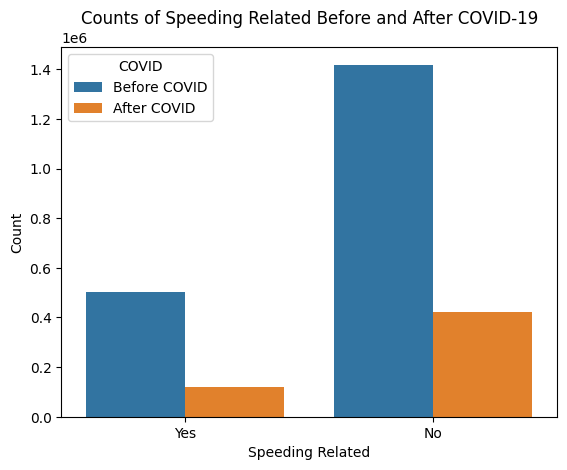

None


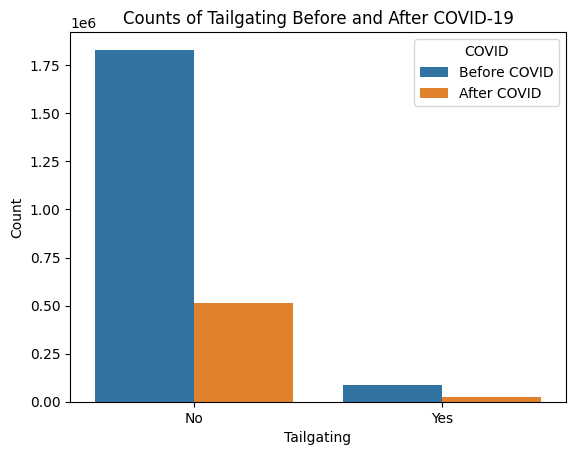

None


In [32]:
for c in aggr_flags:
    cx = c+'x'
    ax = sns.countplot(df, x=cx, hue='POST_COVIDx')
    plt.title('Counts of ' + c.replace('_',' ').title() + ' Before and After COVID-19')
    plt.xlabel(c.replace('_',' ').title())
    plt.ylabel('Count')
    ax.legend_.set_title("COVID")
    plt.savefig('images/countplot_COVID_' + c + '.png')
    print(plt.show())

### <a id='aggr-rate'>Create Aggressive Driving Rates by Date</a>

In [33]:
set(df.columns.tolist())

{'AGGRESSIVE_DRIVING',
 'AGGRESSIVE_DRIVINGx',
 'COUNTY',
 'COUNTYx',
 'CRASH_DATE',
 'CRASH_MN_NAME',
 'CRASH_MONTH',
 'CRASH_YEAR',
 'CRN',
 'DRIVER_16YR',
 'DRIVER_17YR',
 'DRIVER_18YR',
 'DRIVER_19YR',
 'DRIVER_20YR',
 'DRIVER_50_64YR',
 'DRIVER_65_74YR',
 'DRIVER_75PLUS',
 'DRIVER_COUNT_16YR',
 'DRIVER_COUNT_17YR',
 'DRIVER_COUNT_18YR',
 'DRIVER_COUNT_19YR',
 'DRIVER_COUNT_20YR',
 'DRIVER_COUNT_50_64YR',
 'DRIVER_COUNT_65_74YR',
 'DRIVER_COUNT_75PLUS',
 'NHTSA_AGG_DRIVING',
 'NHTSA_AGG_DRIVINGx',
 'NO_CLEARANCE',
 'NO_CLEARANCEx',
 'POST_COVID',
 'POST_COVIDx',
 'RUNNING_RED_LT',
 'RUNNING_RED_LTx',
 'RUNNING_STOP_SIGN',
 'RUNNING_STOP_SIGNx',
 'SPEEDING',
 'SPEEDING_RELATED',
 'SPEEDING_RELATEDx',
 'SPEEDINGx',
 'TAILGATING',
 'TAILGATINGx',
 'URBAN_RURAL',
 'URBAN_RURALx'}

In [34]:
for c in aggr_flags:
    print(c + ': ' + str(df[c].isna().sum()))

AGGRESSIVE_DRIVING: 0
NHTSA_AGG_DRIVING: 0
NO_CLEARANCE: 0
RUNNING_RED_LT: 0
RUNNING_STOP_SIGN: 0
SPEEDING: 0
SPEEDING_RELATED: 0
TAILGATING: 0


In [35]:
summ = df.groupby(['CRASH_DATE', 'CRASH_MONTH','CRASH_MN_NAME','CRASH_YEAR']).\
    aggregate(POST_COVID=('POST_COVID', 'median'),
              AGGRESSIVE_DRIVING_rate=('AGGRESSIVE_DRIVING','mean'),
              NHTSA_AGG_DRIVING_rate=('NHTSA_AGG_DRIVING','mean'),
              NO_CLEARANCE_rate=('NO_CLEARANCE','mean'),
              RUNNING_RED_LT_rate=('RUNNING_RED_LT','mean'),
              RUNNING_STOP_SIGN_rate=('RUNNING_STOP_SIGN','mean'),
              SPEEDING_rate=('SPEEDING','mean'),
              SPEEDING_RELATED_rate=('SPEEDING_RELATED','mean'),
              TAILGATING_rate=('TAILGATING','mean'),
              TOTAL_CRASHES=('CRN','count')).\
    reset_index().\
    copy()

In [36]:
summ

,CRASH_DATE,CRASH_MONTH,CRASH_MN_NAME,CRASH_YEAR,POST_COVID,AGGRESSIVE_DRIVING_rate,NHTSA_AGG_DRIVING_rate,NO_CLEARANCE_rate,RUNNING_RED_LT_rate,RUNNING_STOP_SIGN_rate,SPEEDING_rate,SPEEDING_RELATED_rate,TAILGATING_rate,TOTAL_CRASHES
0,2005-01-01,1,Jan,2005,0.0,0.640866,0.050964,0.052715,0.033047,0.024208,0.031454,0.398232,0.032171,12558
1,2005-02-01,2,Feb,2005,0.0,0.628417,0.050519,0.061164,0.035002,0.027695,0.036716,0.369418,0.031755,11085
2,2005-03-01,3,Mar,2005,0.0,0.594950,0.055947,0.063644,0.039144,0.026753,0.045996,0.305735,0.039895,10653
3,2005-04-01,4,Apr,2005,0.0,0.570050,0.058107,0.075461,0.041533,0.029248,0.050015,0.240421,0.045627,10257
4,2005-05-01,5,May,2005,0.0,0.553907,0.058330,0.079893,0.039163,0.030409,0.051603,0.219130,0.044600,10852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2024-08-01,8,Aug,2024,1.0,0.574946,0.059387,0.086629,0.039553,0.028041,0.037615,0.205061,0.056195,8773
236,2024-09-01,9,Sep,2024,1.0,0.575126,0.057146,0.083372,0.037105,0.024393,0.033784,0.206940,0.054054,8732
237,2024-10-01,10,Oct,2024,1.0,0.510252,0.048685,0.082015,0.041382,0.026496,0.029211,0.142402,0.061043,10681
238,2024-11-01,11,Nov,2024,1.0,0.522246,0.044395,0.073344,0.035846,0.024772,0.028852,0.194579,0.046338,10294


In [37]:
summ['POST_COVIDx'] = ['After COVID' if x==1 else 'Before COVID' for x in summ['POST_COVID']]

In [38]:
"""for c in aggr_flags:
    var = c + '_rate'
    summ[var] = summ[c + '_cnt']/summ['TOTAL_CRASHES']"""

"for c in aggr_flags:\n    var = c + '_rate'\n    summ[var] = summ[c + '_cnt']/summ['TOTAL_CRASHES']"

### <a id='aggr-viz'>Visualize Aggressive Driving Rates Over Time</a>

In [39]:
chart = alt.Chart(summ).mark_bar().encode(
    x= 'CRASH_DATE', 
    y= 'TOTAL_CRASHES'
 ).properties(
    title='Total Crashes Over Time'
 )

chart

alt.Chart(...)

In [40]:
chart = alt.Chart(summ).mark_line(point=True).encode( 
    x= 'CRASH_DATE', 
    y= 'AGGRESSIVE_DRIVING_rate'
 ).properties(
    title='Aggressive Driving Rate Over Time'
 )

chart

alt.Chart(...)

In [41]:
#summ.columns.to_list()

In [42]:
summ['POST_COVIDx'].value_counts()

POST_COVIDx
Before COVID    182
After COVID      58
Name: count, dtype: int64

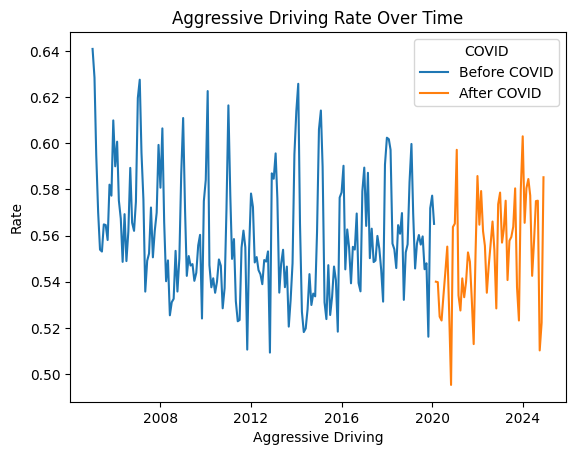

None


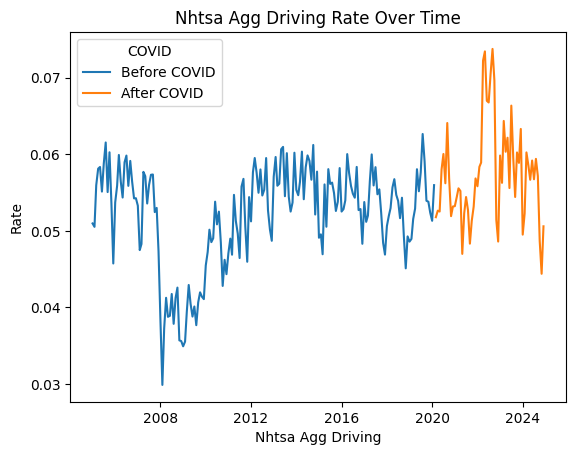

None


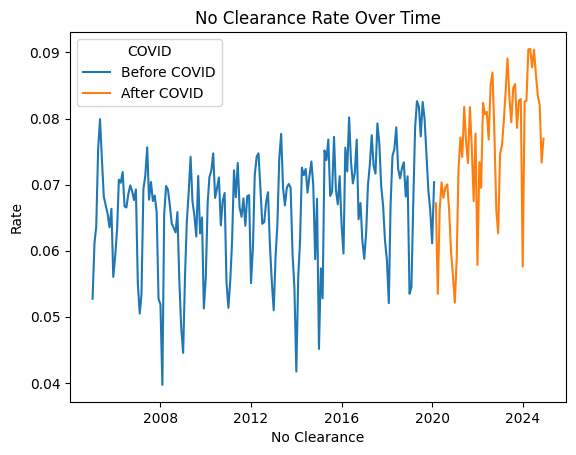

None


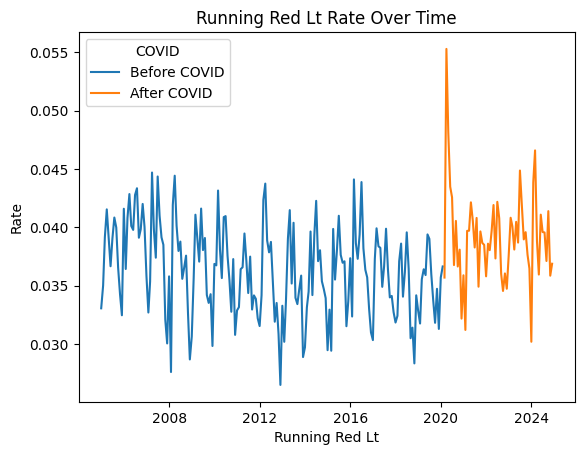

None


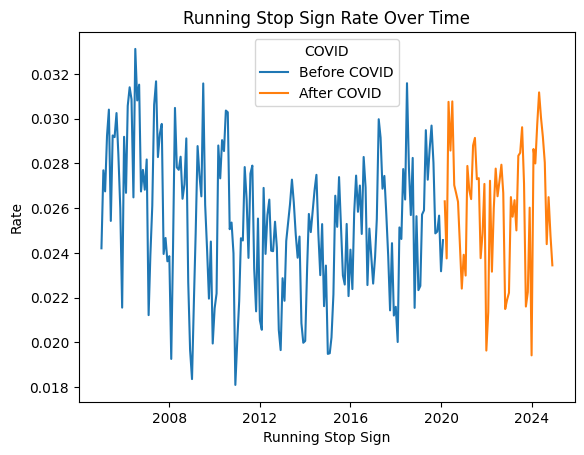

None


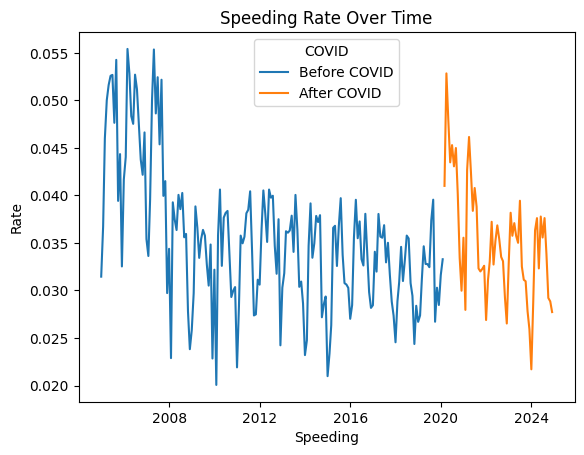

None


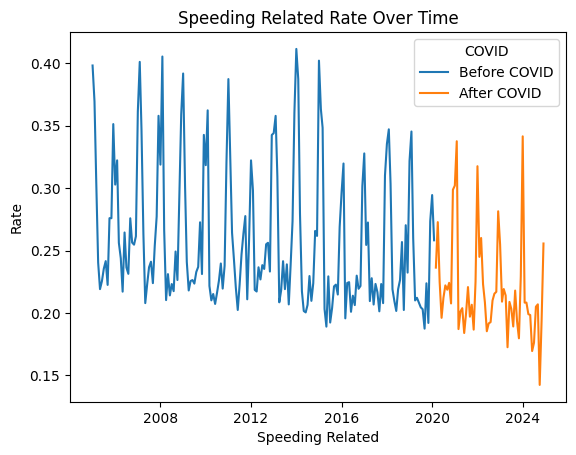

None


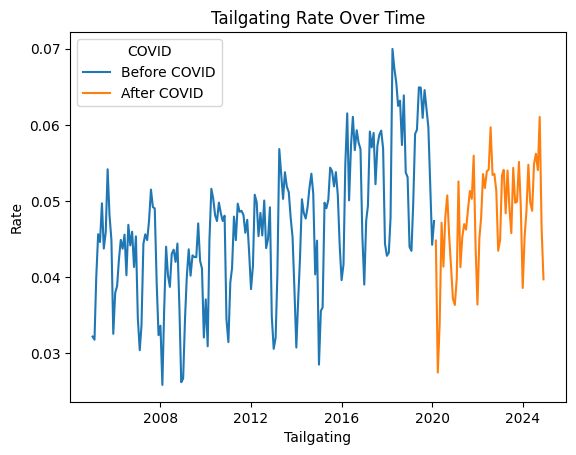

None


In [43]:
for c in aggr_flags:
    cr = c+'_rate'
    ax = sns.lineplot(summ, x='CRASH_DATE', y=cr, hue='POST_COVIDx')
    plt.title(c.replace('_',' ').title() + ' Rate Over Time')
    plt.xlabel(c.replace('_',' ').title())
    plt.ylabel('Rate')
    ax.legend_.set_title("COVID")
    plt.savefig('images/aggr_driv_over_time_' + c + '.png')
    print(plt.show())